## 載入預訓練模型(ResNet50)

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input

# 建立一個輸入張量，指定圖像大小為224x224（RGB色彩通道）
input_tensor = Input(shape=(224, 224, 3))
# 建立 ResNet50 模型
model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=True)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


- 鳳梨: https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/pineapple.jpg?raw=true
- 香蕉: https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/banana.jpg?raw=true
- 柳橙: https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/orange.jpg?raw=true

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# 載入圖像
image_url = tf.keras.utils.get_file(origin=' https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/banana.jpg?raw=true')
image = tf.keras.utils.load_img(image_url, target_size=(224, 224))
image = tf.keras.utils.img_to_array(image) # 將載入的圖像轉換為數組形式
x = np.expand_dims(image.copy(), axis=0) # 將圖像轉換為模型可接受的維度
# 預處理圖像
x = preprocess_input(x)

15190/15190 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras.applications.resnet50 import decode_predictions

# 進行圖像分類預測
pred_proba = model.predict(x) # 返回分類機率
# 解析預測結果
pred_class_idx = pred_proba.argmax(axis=1)[0]  # 找到具有最高機率的類別索引
pred_class = decode_predictions(pred_proba, top=1)[0][0]  # 解析取得預測結果

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


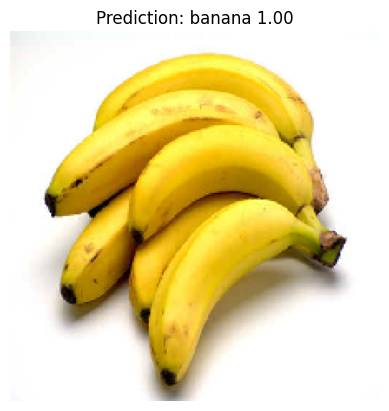

In [10]:
import matplotlib.pylab as plt

plt.imshow(image.astype('uint8'))
plt.axis('off')
predicted_class_name = pred_class[1]
_ = plt.title(f"Prediction: {predicted_class_name} {pred_class[2]:.2f}")

## 使用

In [11]:
!pip install shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 29.2 MB/s eta 0:00:00


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# 載入圖像
image_url = tf.keras.utils.get_file(origin='https://github.com/andy6804tw/crazyai-xai/blob/main/code/dataset/pineapple.jpg?raw=true')
image = tf.keras.utils.load_img(image_url, target_size=(224, 224))
image = tf.keras.utils.img_to_array(image) # 將載入的圖像轉換為數組形式
x = np.expand_dims(image.copy(), axis=0) # 將圖像轉換為模型可接受的維度

In [13]:
import json
import requests

# 下載 ImageNet 類別名稱的 JSON 檔案
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
response = requests.get(url)
class_names = [v[1] for v in response.json().values()]


  0%|          | 0/198 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:23, 83.14s/it]               


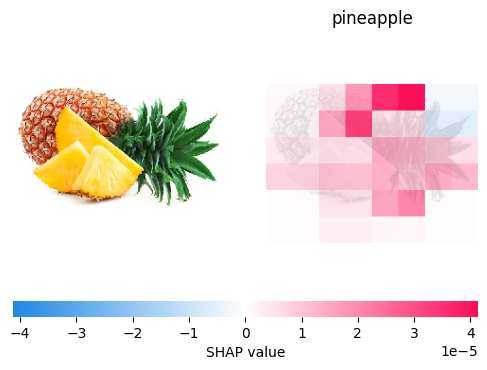

In [15]:
import shap

# 包裝要被解釋的模型
def f(X):
    tmp = X.copy()
    preprocess_input(tmp) # 影像前處理
    return model(tmp)

# 定義一個 masker 用於遮罩圖像的部分區域
masker = shap.maskers.Image("blur(5, 5)", x[0].shape)
# 使用 Partition explainer 解釋模型
explainer = shap.Explainer(f, masker, output_names=class_names)
# 估計 Shapely values
shap_values = explainer(x, max_evals=200, batch_size=1, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values, x.astype(np.uint8))